#Create a Google Drive folder path

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
cd /content/drive/MyDrive

# Import Libraries

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
from random import shuffle
import torch
from torch import nn
import math
from glob import glob
import sys
import shutil  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


%matplotlib inline

# Create a folder in MyDrive
Create a folder in MyDrive named "UNet-AerialSegmentation"
and Change directory pointing this folder

In [ ]:
cd /content/drive/MyDrive/UNet-AerialSegmentation

# Download data
Download "Semantic segmentation of aerial imagery” Dataset and upload the dataset in the "UNet-AerialSegmentation" folder

# Data loader and data augmentation

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
import torchvision.transforms as transforms
import PIL
import random
from scipy import ndimage


class segDataset(torch.utils.data.Dataset):
    def __init__(self, root, training, transform=None):
        super(segDataset, self).__init__()
        self.root = root
        self.training = training
        self.transform = transform
        self.IMG_NAMES = sorted(glob(self.root + '/*/images/*.jpg'))
        self.BGR_classes = {'Water' : [ 41, 169, 226],
                            'Land' : [246,  41, 132],
                            'Road' : [228, 193, 110],
                            'Building' : [152,  16,  60], 
                            'Vegetation' : [ 58, 221, 254],
                            'Unlabeled' : [155, 155, 155]} # in BGR

        self.bin_classes = ['Water', 'Land', 'Road', 'Building', 'Vegetation', 'Unlabeled']


    def __getitem__(self, idx):
        img_path = self.IMG_NAMES[idx]
        mask_path = img_path.replace('images', 'masks').replace('.jpg', '.png')

        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path)
        cls_mask = np.zeros(mask.shape)  
        cls_mask[mask == self.BGR_classes['Water']] = self.bin_classes.index('Water')
        cls_mask[mask == self.BGR_classes['Land']] = self.bin_classes.index('Land')
        cls_mask[mask == self.BGR_classes['Road']] = self.bin_classes.index('Road')
        cls_mask[mask == self.BGR_classes['Building']] = self.bin_classes.index('Building')
        cls_mask[mask == self.BGR_classes['Vegetation']] = self.bin_classes.index('Vegetation')
        cls_mask[mask == self.BGR_classes['Unlabeled']] = self.bin_classes.index('Unlabeled')
        cls_mask = cls_mask[:,:,0] 

        if self.training==True:
            if self.transform:
              image = transforms.functional.to_pil_image(image)
              image = self.transform(image)
              image = np.array(image)

            # 90 degree rotation
            if np.random.rand()<0.5:
              angle = np.random.randint(4) * 90
              image = ndimage.rotate(image,angle,reshape=True)
              cls_mask = ndimage.rotate(cls_mask,angle,reshape=True)

            # vertical flip
            if np.random.rand()<0.5:
              image = np.flip(image, 0)
              cls_mask = np.flip(cls_mask, 0)
            
            # horizonal flip
            if np.random.rand()<0.5:
              image = np.flip(image, 1)
              cls_mask = np.flip(cls_mask, 1)

        image = cv2.resize(image, (512,512))/255.0
        cls_mask = cv2.resize(cls_mask, (512,512)) 
        image = np.moveaxis(image, -1, 0)

        return torch.tensor(image).float(), torch.tensor(cls_mask, dtype=torch.int64)


    def __len__(self):
        return len(self.IMG_NAMES)

In [ ]:
color_shift = transforms.ColorJitter(.1,.1,.1,.1)
blurriness = transforms.GaussianBlur(3, sigma=(0.1, 2.0))

t = transforms.Compose([color_shift, blurriness])
dataset = segDataset('./Semantic segmentation dataset', training = True, transform= t)

len(dataset)

72

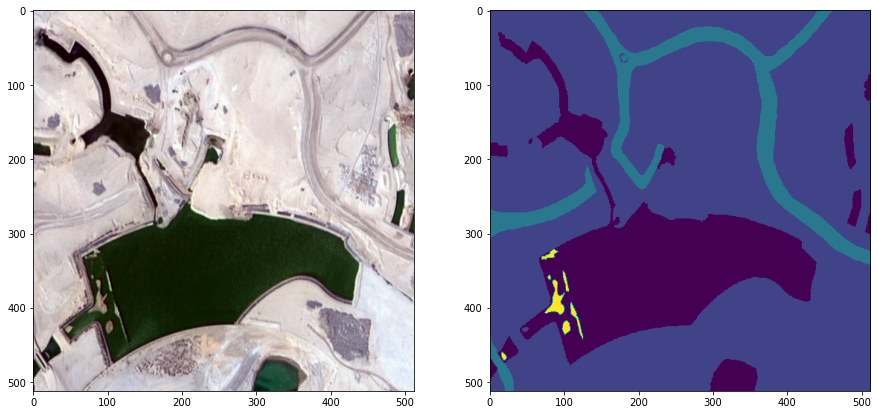

In [ ]:
d = dataset[1]
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(np.moveaxis(d[0].numpy(),0,-1))
plt.subplot(1,2,2)
plt.imshow(d[1].numpy())

In [ ]:
test_num = int(0.1 * len(dataset))
print(f'test data : {test_num}')
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [len(dataset)-test_num, test_num], generator=torch.Generator().manual_seed(101))

test data : 7


In [ ]:
BACH_SIZE = 4
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BACH_SIZE, shuffle=True, num_workers=4)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BACH_SIZE, shuffle=False, num_workers=1)

# U-net model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

#Focal loss

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input, dim=-1)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [ ]:
criterion = FocalLoss(gamma=3/4).to(device)

# mIoU loss

In [ ]:
class mIoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True, n_classes=2):
        super(mIoULoss, self).__init__()
        self.classes = n_classes

    def to_one_hot(self, tensor):
        n,h,w = tensor.size()
        one_hot = torch.zeros(n,self.classes,h,w).to(tensor.device).scatter_(1,tensor.view(n,1,h,w),1)
        return one_hot

    def forward(self, inputs, target):
        # inputs => N x Classes x H x W
        # target_oneHot => N x Classes x H x W

        N = inputs.size()[0]

        # predicted probabilities for each pixel along channel
        inputs = F.softmax(inputs,dim=1)
        
        # Numerator Product
        target_oneHot = self.to_one_hot(target)
        inter = inputs * target_oneHot
        ## Sum over all pixels N x C x H x W => N x C
        inter = inter.view(N,self.classes,-1).sum(2)

        #Denominator 
        union= inputs + target_oneHot - (inputs*target_oneHot)
        ## Sum over all pixels N x C x H x W => N x C
        union = union.view(N,self.classes,-1).sum(2)

        loss = inter/union

        ## Return average loss over classes and batch
        return 1-loss.mean()

In [ ]:
criterion = mIoULoss(n_classes=6).to(device)

# Training task and Accuracy metrics computation

In [ ]:
def acc(label, predicted):
  seg_acc = (y.cpu() == torch.argmax(pred_mask, axis=1).cpu()).sum() / torch.numel(y.cpu())
  return seg_acc

In [ ]:
from keras import backend as K
from sklearn.metrics import precision_score, recall_score

def recall_m(y_true, y_pred):
    true_positives = (y_true.cpu() == torch.argmax(y_pred, axis=1).cpu()).sum()
    possible_positives = torch.sum(torch.clip(y_true,0,1))
    recall = true_positives / (possible_positives + K.epsilon())

    return recall

def precision_m(y_true, y_pred):
    true_positives = (y_true.cpu() == torch.argmax(y_pred, axis=1).cpu()).sum()
    possible_positives = torch.sum(torch.clip(y_pred,0,1))
    precision = true_positives / (possible_positives + K.epsilon())

    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))




In [ ]:
min_loss = torch.tensor(float('inf'))

model = UNet(n_channels=3, n_classes=6, bilinear=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

In [ ]:
os.makedirs('./saved_models', exist_ok=True)

N_EPOCHS = 100
N_DATA = len(train_dataset)
N_TEST = len(test_dataset)

plot_losses = []
plot_prec=[]
plot_recall=[]
plot_f1_score=[]
scheduler_counter = 0

for epoch in range(N_EPOCHS):
  # training
  model.train()
  loss_list = []
  acc_list = []
  prec_list=[]
  recall_list=[]
  f1_list=[]

  for batch_i, (x, y) in enumerate(train_dataloader):

      pred_mask = model(x.to(device))  
      loss = criterion(pred_mask, y.to(device))

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      loss_list.append(loss.cpu().detach().numpy())
      acc_list.append(acc(y,pred_mask).numpy())
      recall_list.append(recall_m(y,pred_mask).cpu().detach().numpy())
      prec_list.append(precision_m(y,pred_mask).cpu().detach().numpy())
      f1_list.append(f1_m(y,pred_mask).cpu().detach().numpy())
      sys.stdout.write(
          "\r[Epoch %d/%d] [Batch %d/%d] [Loss: %f (%f)]"
          % (
              epoch,
              N_EPOCHS,
              batch_i,
              len(train_dataloader),
              loss.cpu().detach().numpy(),
              np.mean(loss_list),
          )
      )
  scheduler_counter += 1
  # testing
  model.eval()
  val_loss_list = []
  val_acc_list = []
  val_prec_list=[]
  val_recall_list=[]
  val_f1_list=[]
  for batch_i, (x, y) in enumerate(test_dataloader):
      with torch.no_grad():    
          pred_mask = model(x.to(device))  
      val_loss = criterion(pred_mask, y.to(device))
      val_loss_list.append(val_loss.cpu().detach().numpy())
      val_acc_list.append(acc(y,pred_mask).numpy())
      val_prec_list.append(precision_m(y,pred_mask).cpu().detach().numpy())
      val_recall_list.append(recall_m(y,pred_mask).cpu().detach().numpy())
      val_f1_list.append(f1_m(y,pred_mask).detach().cpu().numpy())
     
 
  print(' epoch {} - loss : {:.5f} - acc : {:.2f} - val loss : {:.5f} - val acc : {:.2f} - prec : {:.2f} - recall : {:.2f} - f1_score : {:.2f} - val_prec : {:.2f} - val_recall : {:.2f} - val_f1_score : {:.2f}'.format(epoch, 
                                                                                                                                                                                                                         np.mean(loss_list), 
                                                                                                                                                                                                                         np.mean(acc_list),
                                                                                                                                                                                                                         np.mean(val_loss_list),
                                                                                                                                                                                                                         np.mean(val_acc_list),
                                                                                                                                                                                                                         np.mean(prec_list),
                                                                                                                                                                                                                         np.mean(recall_list),
                                                                                                                                                                                                                         np.mean(f1_list),
                                                                                                                                                                                                                         np.mean(val_prec_list),
                                                                                                                                                                                                                         np.mean(val_recall_list),
                                                                                                                                                                                                                         np.mean(val_f1_list)))
  plot_losses.append([epoch, np.mean(loss_list), np.mean(val_loss_list)])
  plot_prec.append([epoch, np.mean(prec_list),np.mean(val_prec_list)])
  plot_recall.append([epoch, np.mean(recall_list),np.mean(val_recall_list)])
  plot_f1_score.append([epoch, np.mean(f1_list),np.mean(val_f1_list)])

  compare_loss = np.mean(val_loss_list)
  is_best = compare_loss < min_loss
  if is_best == True:
    scheduler_counter = 0
    min_loss = min(compare_loss, min_loss)
    torch.save(model.state_dict(), './saved_models/unet_epoch_{}_{:.5f}.pt'.format(epoch,np.mean(val_loss_list)))
  
  if scheduler_counter > 5:
    lr_scheduler.step()
    print(f"lowering learning rate to {optimizer.param_groups[0]['lr']}")
    scheduler_counter = 0


#Graph Plots

In [ ]:
# plot loss
plot_losses = np.array(plot_losses)
plt.plot(plot_losses[:,0], plot_losses[:,1], color='b', linewidth=2)
plt.plot(plot_losses[:,0], plot_losses[:,2], color='r', linewidth=2)
plt.title('mIoU Loss', fontsize=20)
plt.xlabel('Epoch',fontsize=20)
plt.ylabel('loss',fontsize=20)
plt.grid()
plt.legend(['Training', 'Validation']) # using a named size
plt.show()
#plot Precision
plot_prec = np.array(plot_prec)
plt.plot(plot_prec[:,0], plot_prec[:,1], color='b', linewidth=2)
plt.plot(plot_prec[:,0], plot_prec[:,2], color='r', linewidth=2)
plt.title('Precision', fontsize=20)
plt.xlabel('Epoch',fontsize=20)
plt.ylabel('Precision',fontsize=20)
plt.grid()
plt.legend(['Training', 'Validation']) # using a named size
plt.show()
#plot Recall
plot_recall = np.array(plot_recall)
plt.plot(plot_recall[:,0], plot_recall[:,1], color='b', linewidth=2)
plt.plot(plot_recall[:,0], plot_recall[:,2], color='r', linewidth=2)
plt.title('Recall', fontsize=20)
plt.xlabel('Epoch',fontsize=20)
plt.ylabel('Recall',fontsize=20)
plt.grid()
plt.legend(['Training', 'Validation']) # using a named size
plt.show()
#plot F1-Score
plot_f1_score = np.array(plot_f1_score)
plt.plot(plot_f1_score[:,0], plot_f1_score[:,1], color='b', linewidth=2)
plt.plot(plot_f1_score[:,0], plot_f1_score[:,2], color='r', linewidth=2)
plt.title('F1-Score', fontsize=20)
plt.xlabel('Epoch',fontsize=20)
plt.ylabel('F1-Score',fontsize=20)
plt.grid()
plt.legend(['Training', 'Validation']) # using a named size
plt.show()


# Loading a pre-trained model and application of the model on an aerial image 

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/UNet-AerialSegmentation/saved_models/unet_epoch_95_0.62743.pt'))

<All keys matched successfully>

In [ ]:
model.eval()

for batch_i, (x, y) in enumerate(test_dataloader):
    for j in range(len(x)):
        result = model(x.to(device)[j:j+1])
        mask = torch.argmax(result, axis=1).cpu().detach().numpy()[0]
        im = np.moveaxis(x.to(device)[j].cpu().detach().numpy(), 0, -1).copy()*255
        im = im.astype(int)
        gt_mask = y[j]

        plt.figure(figsize=(12,12))

        plt.subplot(1,3,1)
        im = np.moveaxis(x.to(device)[j].cpu().detach().numpy(), 0, -1).copy()*255
        im = im.astype(int)
        plt.imshow(im)

        plt.subplot(1,3,2)
        plt.imshow(gt_mask)

        plt.subplot(1,3,3)
        plt.imshow(mask)
        plt.show()

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/ortofoto/Scavo75_clip_rect.tif'
img = cv2.imread(path)
img = cv2.resize(img, (512,512))/255.0
test_img = np.moveaxis(img, -1, 0)
test_img = torch.from_numpy(np.array([test_img]).astype(dtype='float32'))

t_result = model(test_img.to(device))

mask = torch.argmax(t_result, axis=1).cpu().detach().numpy()[0]

im = np.moveaxis(x.to(device)[j].cpu().detach().numpy(), 0, -1).copy()*255
im = im.astype(int)
gt_mask = y[j]

plt.figure(figsize=(12,12))

plt.subplot(1,3,1)
im = np.moveaxis(x.to(device)[j].cpu().detach().numpy(), 0, -1).copy()*255
im = im.astype(int)
plt.imshow(img)

# plt.subplot(1,3,2)
# plt.imshow(gt_mask)
sp = path.split('.')

plt.subplot(1,3,2)
plt.imshow(mask)
plt.savefig(sp[0]+'_mask.'+sp[1])
plt.show()





